## Introduction

## Jupyter Notebook Setup

In [1]:
import pandas as pd
import numpy as np
from nltk.stem import SnowballStemmer
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS as stop
import string
from collections import Counter
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import compute_class_weight
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings

In [2]:
tf.random.set_seed(9)
# tf.random.set_random_seed(9)
warnings.filterwarnings('ignore')

stemmer = SnowballStemmer("english")
nlp = en_core_web_sm.load()
punc = set(string.punctuation)

In [3]:
# Setup before git push.
'''
Change the default plotly renderer to colab 
because plotly's plot doesn't render on the 
internet outside of certain Python environments.
Use iframe if rendering in localhost.
'''
import plotly.io as pio
pio.renderers.default = 'iframe' # for localhost
# pio.renderers.default = 'colab' # before git commit
# Rerun all cells with plotly plots after running this cell (before git commit).

## Reading The Data

In [4]:
df = pd.read_parquet('../scraped_data/reviews.parquet.gzip')
df.head()

,title,date,location,rating,text
0,"Which iPhone you should Purchase ? iPhone 8, X...",2018-12-12,India,3.0,NOTE:@ This is detailed comparison between iPh...
1,Don't buy iPhone xr from Amazon.,2018-11-17,India,1.0,Very bad experience with this iPhone xr phone....
2,Happy with the purchase,2019-01-27,India,5.0,Amazing phone with amazing camera coming from ...
3,Amazon is not an apple authorised reseller. Pl...,2019-05-02,India,1.0,So I got the iPhone XR just today. The product...
4,Excellent Battery life and buttery smooth UI,2019-05-24,India,5.0,I've been an android user all my life until I ...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3870 entries, 0 to 3869
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   title     3870 non-null   object        
 1   date      3870 non-null   datetime64[ns]
 2   location  3870 non-null   object        
 3   rating    3870 non-null   float32       
 4   text      3870 non-null   object        
dtypes: datetime64[ns](1), float32(1), object(3)
memory usage: 136.2+ KB


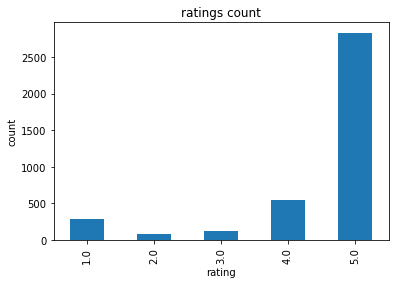

In [6]:
df['rating'].value_counts().sort_index().plot.bar(xlabel='rating', ylabel='count', title='ratings count')
plt.show()

In [7]:
def to_clean_list(doc):
    # lower text and remove punctuations
    s = ""
    for char in doc.lower():
        s += char if char not in punc else ""
    words = []
    for token in s.lower().split():
        words.append(token.strip())
    return words

## Feature Engineering & Quick EDA

In [8]:
word_counter = Counter()
positive_counter = Counter()
negative_counter = Counter()

for idx in df.index:
    doc = df.loc[idx, 'text']
    rating = df.loc[idx, 'rating']
    for i in to_clean_list(doc):
        word_counter[i] += 1
        if rating > 3:
            positive_counter[i] += 1
        else:
            negative_counter[i] += 1
        
word_counter.most_common()[:20]

[('is', 2554),
 ('the', 2483),
 ('and', 1786),
 ('i', 1532),
 ('phone', 1503),
 ('to', 1407),
 ('it', 1328),
 ('good', 1242),
 ('a', 1176),
 ('for', 1112),
 ('iphone', 1017),
 ('in', 939),
 ('this', 889),
 ('of', 832),
 ('with', 781),
 ('battery', 766),
 ('not', 729),
 ('product', 681),
 ('camera', 637),
 ('but', 635)]

In [9]:
weight_neg, weight_pos = compute_class_weight('balanced', [0,1], df['rating']>3)

In [10]:
pos_neg_ratios = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(word_counter.most_common()):
    if(cnt > 10):
        pos_neg_ratio = (positive_counter[term] * weight_pos) / float((negative_counter[term] * weight_neg)+1)
        pos_neg_ratios[term] = pos_neg_ratio
        
# Convert ratios to logs
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios[word] = np.log(ratio)

pos_neg_ratios.most_common()[:10]

[('perfect', 3.9846392189531774),
 ('deal', 3.8233710713570552),
 ('loved', 3.501787447229593),
 ('amazing', 3.3303210789932742),
 ('fantastic', 3.0522623493273984),
 ('lag', 2.8086402666696477),
 ('wonderful', 2.7371813026875027),
 ('love', 2.704794086108308),
 ('loving', 2.6994409747046557),
 ('beast', 2.6994409747046557)]

In [11]:
x = [i[1] for i in pos_neg_ratios.most_common()]

fig = go.Figure([go.Histogram(x=x, nbinsx=len(x)//3)])

fig.show()

In [12]:
corpus = set()

for k, v in word_counter.items():
    if v > 10:
        corpus.add(k)
        
corpus = sorted(corpus)
idx2word = dict(enumerate(corpus))
word2idx = {v:k for k, v in idx2word.items()}

len(corpus)

735

In [13]:
arr_bow = np.zeros((df.shape[0], len(corpus)), dtype=np.uint32)

arr_bow.shape

(3870, 735)

In [14]:
for row_idx, doc in enumerate(df['text']):
    for i in to_clean_list(doc):
        if i in corpus:
            col_idx = word2idx[i]
            ## One hot encoding
            arr_bow[row_idx, col_idx] = 1
            ## Bag of Words
            # arr_bow[row_idx, col_idx] += 1
        
arr_bow[:5, :30]

array([[0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 1]], dtype=uint32)

In [15]:
arr_bow.shape

(3870, 735)

## Removing Noise

In [16]:
(arr_bow.sum(axis=1)==0).sum()

56

In [17]:
df[arr_bow.sum(axis=1)==0]

,title,date,location,rating,text
1115,Nice !!!!,2020-02-12,India,5.0,NYC
1165,Value for money,2020-03-07,India,2.0,Awesom
1244,Superb,2019-10-16,India,5.0,Amazing.excellent.
1382,Super,2019-11-05,India,5.0,God
1560,Babboy,2019-11-12,India,5.0,Ammo
1610,Awesome,2019-11-04,India,5.0,Woooooow
1613,👌🏻,2019-09-10,India,5.0,👌🏻
1859,Best iPhone,2019-12-24,India,5.0,😜😜😜❤️❤️
1938,EXCEPT DELHIVERY SERVICES All things are good .,2019-10-07,India,5.0,Superb👌👌👌
1966,Great,2019-09-11,India,5.0,Hreat


In [18]:
X = arr_bow[arr_bow.sum(axis=1)!=0]
y = keras.utils.to_categorical(df[arr_bow.sum(axis=1)!=0]['rating'])[:, 1:]
X.shape, y.shape

((3814, 735), (3814, 5))

In [19]:
np.unique(np.argmax(y, axis=1) + 1, return_counts=True)

(array([1, 2, 3, 4, 5]), array([ 280,   79,  126,  543, 2786]))

## Train Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=9, stratify=y_test)

## Training The Model

In [21]:
model = keras.Sequential([
    keras.Input(shape=(X.shape[1],)),
    keras.layers.Dense(8, activation= 'linear', kernel_initializer=keras.initializers.Zeros()),
    keras.layers.Dense(5, activation= 'softmax', kernel_initializer=keras.initializers.RandomNormal())
])

optimizer = keras.optimizers.SGD(0.1)
loss = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', 'AUC'])

In [22]:
callbacks = [
    # Early Stopping
    keras.callbacks.EarlyStopping(patience=12),
    # Model Checkpoint
    keras.callbacks.ModelCheckpoint(filepath= 'tf_models/bow_model.ckpt', verbose= 0, 
                                    save_best_only= True, save_weights_only= True),
    # Learning Rate Scheduler
    keras.callbacks.ReduceLROnPlateau(patience=4)
]

history = model.fit(
    X_train, y_train, batch_size=128, epochs=300, 
    validation_data=(X_val, y_val), callbacks=callbacks
)

Epoch 1/300
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
21/21 [==============================] - 0s 20ms/step - loss: 1.3309 - accuracy: 0.6969 - auc: 0.8417 - val_loss: 1.1118 - val_accuracy: 0.7295 - val_auc: 0.8773 - lr: 0.1000
Epoch 2/300
21/21 [==============================] - 0s 7ms/step - loss: 1.0217 - accuracy: 0.7306 - auc: 0.8731 - val_loss: 0.9607 - val_accuracy: 0.7295 - val_auc: 0.8753 - lr: 0.1000
Epoch 3/300
21/21 [==============================] - 0s 7ms/step - loss: 0.9378 - accuracy: 0.7306 - auc: 0.8774 - val_loss: 0.9226 - val_accuracy: 0.7295 - val_auc: 0.8811 - lr: 0.1000
Epoch 4/300
21/21 [==============================] - 0s 7ms/step - loss: 0.9114 - accuracy: 0.7306 - auc: 0.8847 - val_loss: 0.9041 - val_accuracy: 0.7295 - val_auc: 0.8910 - lr: 0.1000
Epoch 5/300
21/21 [==============================] - 0s 7ms/step - loss: 0.8943 - accuracy: 0.7306 - auc: 0.8959 - val_loss: 0.8891 - val_accuracy: 0.7295 - val_auc: 0.9017 -

Epoch 43/300
21/21 [==============================] - 0s 7ms/step - loss: 0.5841 - accuracy: 0.7928 - auc: 0.9565 - val_loss: 0.6726 - val_accuracy: 0.7714 - val_auc: 0.9396 - lr: 0.1000
Epoch 44/300
21/21 [==============================] - 0s 7ms/step - loss: 0.5805 - accuracy: 0.7928 - auc: 0.9570 - val_loss: 0.6733 - val_accuracy: 0.7714 - val_auc: 0.9397 - lr: 0.1000
Epoch 45/300
21/21 [==============================] - 0s 7ms/step - loss: 0.5770 - accuracy: 0.7947 - auc: 0.9573 - val_loss: 0.6731 - val_accuracy: 0.7696 - val_auc: 0.9395 - lr: 0.1000
Epoch 46/300
21/21 [==============================] - 0s 6ms/step - loss: 0.5735 - accuracy: 0.7969 - auc: 0.9578 - val_loss: 0.6734 - val_accuracy: 0.7679 - val_auc: 0.9398 - lr: 0.1000
Epoch 47/300
21/21 [==============================] - 0s 8ms/step - loss: 0.5704 - accuracy: 0.7996 - auc: 0.9583 - val_loss: 0.6734 - val_accuracy: 0.7731 - val_auc: 0.9399 - lr: 0.1000
Epoch 48/300
21/21 [==============================] - 0s 6ms/step

## Load The Neural Network's Best Weight

In [23]:
model.load_weights('tf_models/bow_model.ckpt')

## Evaluating the neural network

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'auc', 'val_loss', 'val_accuracy', 'val_auc', 'lr'])

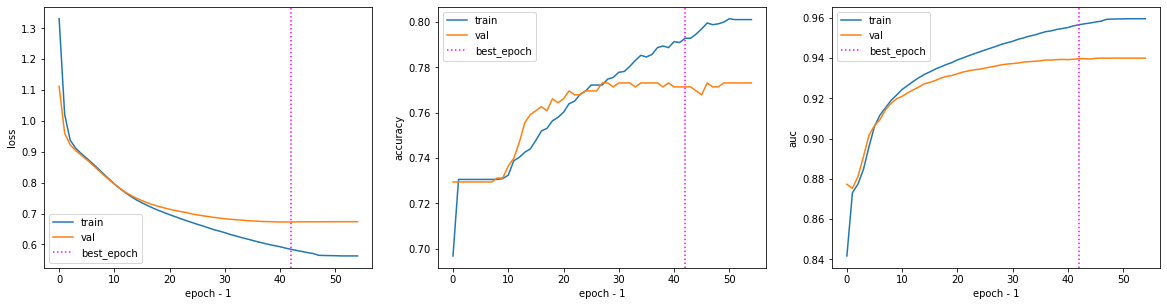

In [25]:
fig, axes = plt.subplots(1,3, figsize=(20, 4.8))

n_epoch = len(history.history['loss'])
xticks, xticksloc = range(1, n_epoch+1), range(n_epoch)
best_epoch = n_epoch - 12 - 1

for ax, to_plot in zip(axes, ['loss', 'accuracy', 'auc']):
    ax.plot(history.history[to_plot], label='train')
    ax.plot(history.history[f'val_{to_plot}'], label='val')
    ax.axvline(best_epoch, ls=':', c='magenta', label='best_epoch')
    ax.set_xlabel('epoch - 1')
    ax.set_ylabel(to_plot)
    ax.legend()

plt.show()

In [26]:
print(classification_report([np.argmax(i) + 1 for i in y_train], np.argmax(model.predict(X_train), axis=1) + 1))

              precision    recall  f1-score   support

           1       0.61      0.66      0.64       196
           2       0.00      0.00      0.00        55
           3       0.00      0.00      0.00        88
           4       0.61      0.16      0.25       380
           5       0.82      0.99      0.90      1950

    accuracy                           0.79      2669
   macro avg       0.41      0.36      0.36      2669
weighted avg       0.73      0.79      0.74      2669



In [50]:
print(classification_report([np.argmax(i) + 1 for i in y_val], np.argmax(model.predict(X_val), axis=1) + 1))

              precision    recall  f1-score   support

           1       0.61      0.60      0.60        42
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00        19
           4       0.45      0.12      0.19        82
           5       0.80      0.97      0.88       418

    accuracy                           0.77       573
   macro avg       0.37      0.34      0.33       573
weighted avg       0.69      0.77      0.71       573



In [27]:
print(classification_report([np.argmax(i) + 1 for i in y_test], np.argmax(model.predict(X_test), axis=1) + 1))

              precision    recall  f1-score   support

           1       0.53      0.45      0.49        42
           2       0.00      0.00      0.00        12
           3       0.00      0.00      0.00        19
           4       0.39      0.11      0.17        81
           5       0.79      0.97      0.87       418

    accuracy                           0.76       572
   macro avg       0.34      0.31      0.31       572
weighted avg       0.67      0.76      0.70       572



## Word2Vec Visualization

### Pre-Visualization Phase

In [77]:
def sentiment(pos_neg_val):
    if pos_neg_val >= 0:
        z = 'Positive'
    else:
        z = 'Negative'
    return z

df_corpus = pd.DataFrame({
    'word':list(corpus),
    'polarity':[pos_neg_ratios[w] for w in corpus],
    'sentiment':[sentiment(pos_neg_ratios[w]) for w in corpus],
    'is_stopword':[nlp(i)[0].is_stop for i in corpus],
#     'pos_':[nlp(i)[0].pos_ for i in corpus]
})

df_corpus.head()

,word,polarity,sentiment,is_stopword
0,1,-0.756158,Negative,False
1,10,-0.783993,Negative,False
2,100,0.428123,Positive,False
3,1080p,-1.198907,Negative,False
4,11,0.741566,Positive,False


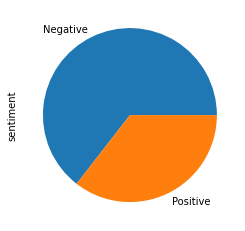

In [63]:
df_corpus['sentiment'].value_counts().plot.pie()
plt.show()

In [61]:
model.weights[0].numpy().shape

(735, 8)

In [85]:
def plot_word_scatter(points, polarity_cutoff=0, col_mask='sentiment', colors=['red', 'green'], title=''):
    if title != '':
        title = f'{title} (polarity cutoff = {polarity_cutoff:.2f})'
    
    fig = go.Figure()
    for mask_val, c in zip(np.unique(df_corpus[col_mask]), colors):
        mask = (df_corpus[col_mask] == mask_val) & (abs(df_corpus['polarity']) >= polarity_cutoff)
        p = points[mask]
        n = mask_val
        t = df_corpus.loc[mask, 'word']
        fig.add_trace(
            go.Scatter(
                x=p[:, 0],
                y=p[:, 1],
                marker_color=c,
                mode='markers',
                name=n,
                text=t
            )
        )
    fig.update_layout(showlegend=False, title_text=title, title_x=0.5)
    fig.show()

### Visualization using T-SNE

In [33]:
tsne_scatter = TSNE(n_components=2, random_state=9).fit_transform(model.weights[0].numpy())

In [86]:
plot_word_scatter(tsne_scatter, title="vector T-SNE for most polarized words")

In [103]:
plot_word_scatter(tsne_scatter, 1., title="vector T-SNE for most polarized words")

In [36]:
pca_scatter = PCA(n_components=2, random_state=9).fit_transform(model.weights[0].numpy())

In [89]:
plot_word_scatter(pca_scatter, title="vector PCA for most polarized words")

In [90]:
plot_word_scatter(pca_scatter, 1., title="vector PCA for most polarized words")

In [39]:
umap_scatter = UMAP(n_components=2, random_state=9).fit_transform(model.weights[0].numpy())

In [91]:
plot_word_scatter(umap_scatter, title="vector UMAP for most polarized words")

In [92]:
plot_word_scatter(umap_scatter, 1., title="vector UMAP for most polarized words")

## Most Similar Words

In [42]:
def get_closest_words(focus):
    closest = Counter()
    weights = model.weights[0].numpy()
    x = weights[word2idx[focus]]
    for word in corpus:
        y = weights[word2idx[word]]
        ## euclidian distance
        closest[word] = np.sqrt(np.sum((x - y) ** 2))
    return closest.most_common()[::-1]

In [104]:
get_closest_words('superb')

[('superb', 0.0),
 ('happy', 0.02807279),
 ('super', 0.0504414),
 ('perfect', 0.061480682),
 ('ios', 0.06888325),
 ('loved', 0.078932844),
 ('love', 0.07928542),
 ('always', 0.08214029),
 ('really', 0.085043535),
 ('everything', 0.08687289),
 ('genuine', 0.09070563),
 ('deal', 0.09347352),
 ('delivery', 0.106105216),
 ('just', 0.10654144),
 ('say', 0.108292565),
 ('than', 0.11104513),
 ('part', 0.1112643),
 ('full', 0.113994986),
 ('for', 0.11446757),
 ('so', 0.11731967),
 ('you', 0.120317005),
 ('performance', 0.12149725),
 ('fast', 0.12341948),
 ('still', 0.12734966),
 ('difference', 0.1337238),
 ('like', 0.1341585),
 ('can', 0.13581607),
 ('big', 0.1412668),
 ('anything', 0.14173403),
 ('loving', 0.14737578),
 ('years', 0.1496082),
 ('reader', 0.15194464),
 ('was', 0.15330285),
 ('quite', 0.15398118),
 ('life', 0.1541567),
 ('size', 0.15495387),
 ('thanks', 0.15737754),
 ('nice', 0.15959221),
 ('simple', 0.15970853),
 ('all', 0.16242938),
 ('satisfied', 0.16291061),
 ('using', 0.163

In [105]:
get_closest_words('worst')

[('worst', 0.0),
 ('defective', 0.1259599),
 ('problem', 0.14309591),
 ('bad', 0.15529656),
 ('disappointed', 0.15552475),
 ('network', 0.20006578),
 ('dont', 0.20065926),
 ('me', 0.21882223),
 ('service', 0.2308427),
 ('return', 0.25246236),
 ('gets', 0.25704336),
 ('video', 0.25726444),
 ('when', 0.2625232),
 ('not', 0.27484545),
 ('by', 0.28046942),
 ('doesnt', 0.28098255),
 ('hang', 0.28718078),
 ('working', 0.29003984),
 ('slow', 0.29031813),
 ('has', 0.3015371),
 ('customer', 0.3115637),
 ('stopped', 0.31258383),
 ('month', 0.31491485),
 ('to', 0.32950032),
 ('disappointing', 0.33223304),
 ('poor', 0.3325659),
 ('hanging', 0.3394491),
 ('3', 0.3439776),
 ('front', 0.34411883),
 ('old', 0.3456517),
 ('got', 0.34866863),
 ('started', 0.3503646),
 ('center', 0.35440412),
 ('sometimes', 0.35868886),
 ('faulty', 0.359098),
 ('stuck', 0.3595427),
 ('call', 0.36055705),
 ('such', 0.3605689),
 ('expected', 0.36200067),
 ('never', 0.36426324),
 ('work', 0.36428952),
 ('think', 0.36538917)

In [45]:
get_closest_words('camera')

[('camera', 0.0),
 ('but', 0.076034635),
 ('battery', 0.12410944),
 ('in', 0.13212727),
 ('face', 0.14083798),
 ('use', 0.15897614),
 ('before', 0.17346863),
 ('up', 0.1820425),
 ('little', 0.18437049),
 ('unlock', 0.18511505),
 ('value', 0.19395043),
 ('though', 0.20099913),
 ('being', 0.2021185),
 ('display', 0.20248032),
 ('were', 0.2034054),
 ('bought', 0.2039055),
 ('overall', 0.2051262),
 ('range', 0.2055205),
 ('backup', 0.20848389),
 ('features', 0.20881256),
 ('of', 0.21263446),
 ('clarity', 0.21370558),
 ('heavy', 0.21409811),
 ('smooth', 0.21494867),
 ('liked', 0.21644342),
 ('almost', 0.21796718),
 ('it', 0.21840133),
 ('buttery', 0.21894701),
 ('fully', 0.21983975),
 ('single', 0.220221),
 ('play', 0.22048143),
 ('be', 0.2206457),
 ('much', 0.22093342),
 ('money', 0.22152609),
 ('earphones', 0.2217258),
 ('didn’t', 0.2221252),
 ('id', 0.22237204),
 ('pubg', 0.22353189),
 ('hours', 0.22358643),
 ('missing', 0.22393677),
 ('bit', 0.22459774),
 ('does', 0.22508256),
 ('about'

In [56]:
get_closest_words('amazon')

[('amazon', 0.0),
 ('product', 0.12153476),
 ('buy', 0.122749254),
 ('received', 0.13324958),
 ('i', 0.1354938),
 ('from', 0.15125541),
 ('never', 0.1539246),
 ('totally', 0.16604495),
 ('on', 0.1690813),
 ('voice', 0.17486541),
 ('first', 0.17568897),
 ('item', 0.17776142),
 ('care', 0.17884669),
 ('replacement', 0.1788979),
 ('very', 0.17889793),
 ('and', 0.17987075),
 ('help', 0.17992634),
 ('even', 0.18119541),
 ('they', 0.18190596),
 ('within', 0.1821749),
 ('a', 0.18234578),
 ('after', 0.18298425),
 ('next', 0.18330105),
 ('customer', 0.18350244),
 ('again', 0.18378885),
 ('center', 0.18381713),
 ('please', 0.18504214),
 ('experience', 0.18516125),
 ('what', 0.18558493),
 ('also', 0.18630436),
 ('take', 0.18667588),
 ('able', 0.18669458),
 ('delivered', 0.18683104),
 ('get', 0.18808554),
 ('faulty', 0.1881213),
 ('2019', 0.18836093),
 ('has', 0.19039488),
 ('buying', 0.19161896),
 ('15', 0.19182573),
 ('speaker', 0.19225901),
 ('huge', 0.19232658),
 ('my', 0.19262141),
 ('patheti

In [46]:
def get_cosine_similarity(focus):
    closest = Counter()
    weights = model.weights[0].numpy()
    x = weights[word2idx[focus]]
    for word in corpus:
        y = weights[word2idx[word]]
        ## cosine similarity
        closest[word] = np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
    return closest.most_common()

In [106]:
get_cosine_similarity('superb')

[('superb', 1.0000001),
 ('happy', 0.9999502),
 ('scanner', 0.9999003),
 ('great', 0.99985063),
 ('best', 0.99972963),
 ('date', 0.9996464),
 ('says', 0.99957883),
 ('say', 0.99952453),
 ('difference', 0.99950063),
 ('mp', 0.9992486),
 ('wonderful', 0.99905986),
 ('makes', 0.99892426),
 ('non', 0.998915),
 ('perfect', 0.9981556),
 ('38k', 0.9980416),
 ('reader', 0.9980236),
 ('13', 0.9976647),
 ('nice', 0.9976546),
 ('deal', 0.9976087),
 ('still', 0.997591),
 ('fantastic', 0.99705285),
 ('charge', 0.99692005),
 ('👍', 0.99656034),
 ('must', 0.99639046),
 ('usage', 0.9963324),
 ('specs', 0.9960629),
 ('job', 0.99563676),
 ('big', 0.9956005),
 ('than', 0.99555874),
 ('far', 0.9955236),
 ('can', 0.99539787),
 ('place', 0.99529684),
 ('hands', 0.9950043),
 ('coming', 0.99472827),
 ('accessories', 0.9946106),
 ('human', 0.9945885),
 ('reviews', 0.9938349),
 ('sale', 0.9937142),
 ('update', 0.99357593),
 ('star', 0.9933636),
 ('beautiful', 0.9929997),
 ('loved', 0.9927258),
 ('fan', 0.9927075

In [107]:
get_cosine_similarity('worst')

[('worst', 0.9999999),
 ('defective', 0.9999788),
 ('faulty', 0.9997246),
 ('return', 0.9996725),
 ('center', 0.9996263),
 ('by', 0.9987743),
 ('huge', 0.9985168),
 ('after', 0.9984242),
 ('15', 0.9977158),
 ('provide', 0.9975226),
 ('today', 0.9971803),
 ('month', 0.99658674),
 ('photo', 0.9964131),
 ('resolution', 0.99537325),
 ('old', 0.99493575),
 ('hanging', 0.9947516),
 ('item', 0.9941819),
 ('bad', 0.9941769),
 ('check', 0.99388754),
 ('suggest', 0.99375015),
 ('customer', 0.9935805),
 ('end', 0.9933905),
 ('please', 0.9922619),
 ('service', 0.991783),
 ('again', 0.9897028),
 ('replacement', 0.9890229),
 ('replaced', 0.98871297),
 ('store', 0.9885455),
 ('two', 0.98773015),
 ('waste', 0.9876059),
 ('switching', 0.9865959),
 ('what', 0.9865206),
 ('eyes', 0.98647887),
 ('centre', 0.98613095),
 ('disappointed', 0.9853776),
 ('support', 0.9848626),
 ('handset', 0.98419285),
 ('true', 0.9837112),
 ('response', 0.9836962),
 ('warranty', 0.9835755),
 ('replace', 0.9834148),
 ('problem

In [49]:
get_cosine_similarity('camera')

[('camera', 1.0),
 ('earphones', 0.99600124),
 ('almost', 0.9854255),
 ('awsome', 0.9848965),
 ('before', 0.9815191),
 ('play', 0.979561),
 ('100', 0.9706055),
 ('battery', 0.9683895),
 ('clarity', 0.95843047),
 ('but', 0.9569558),
 ('something', 0.9527821),
 ('being', 0.9471602),
 ('spend', 0.933884),
 ('money', 0.9280137),
 ('will', 0.92777056),
 ('value', 0.92685926),
 ('good', 0.92608637),
 ('sensor', 0.92103773),
 ('may', 0.9197834),
 ('earphone', 0.9180989),
 ('face', 0.9110169),
 ('bigger', 0.9066371),
 ('ive', 0.90152407),
 ('cover', 0.89819044),
 ('unlock', 0.89291996),
 ('won’t', 0.8905307),
 ('make', 0.8883405),
 ('person', 0.8879903),
 ('because', 0.8816104),
 ('lasts', 0.87503797),
 ('penny', 0.8746339),
 ('in', 0.8725832),
 ('reason', 0.87226516),
 ('little', 0.8700398),
 ('pubg', 0.8674913),
 ('powerful', 0.86607933),
 ('discount', 0.8635988),
 ('charm', 0.8414039),
 ('were', 0.8373696),
 ('operating', 0.8369689),
 ('compare', 0.8262223),
 ('4', 0.82336307),
 ('use', 0.8

In [57]:
get_cosine_similarity('amazon')

[('amazon', 0.99999994),
 ('lens', 0.99748385),
 ('they', 0.9873249),
 ('care', 0.9848384),
 ('take', 0.927334),
 ('experience', 0.92169845),
 ('delivered', 0.8848306),
 ('product', 0.86710924),
 ('went', 0.86399806),
 ('pathetic', 0.8626607),
 ('buy', 0.8518882),
 ('from', 0.834266),
 ('totally', 0.8340331),
 ('i', 0.8329813),
 ('on', 0.82982355),
 ('able', 0.8253888),
 ('wifi', 0.82310903),
 ('received', 0.81799555),
 ('2019', 0.77994955),
 ('off', 0.7700258),
 ('never', 0.74764866),
 ('around', 0.7429933),
 ('choice', 0.7328849),
 ('issue', 0.72924256),
 ('first', 0.7204604),
 ('system', 0.71943855),
 ('notice', 0.70853907),
 ('instead', 0.6987176),
 ('even', 0.69746625),
 ('calls', 0.6974508),
 ('again', 0.6911356),
 ('next', 0.6880032),
 ('voice', 0.68697923),
 ('cost', 0.6832284),
 ('help', 0.6722881),
 ('n', 0.67219377),
 ('has', 0.6699433),
 ('very', 0.66775715),
 ('service', 0.66674656),
 ('get', 0.66423535),
 ('replacement', 0.66009337),
 ('customer', 0.6588251),
 ('a', 0.657